<a href="https://colab.research.google.com/github/yusnivtr/pytorch-deep-learning/blob/main/my_notebook/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

## 1. Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [ ]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [ ]:
y[:5]

array([1, 1, 1, 1, 0])

In [ ]:
# Make Dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"x1":X[:,0],
                        "x2":X[:,1],
                        "label":y})

In [ ]:
circles.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


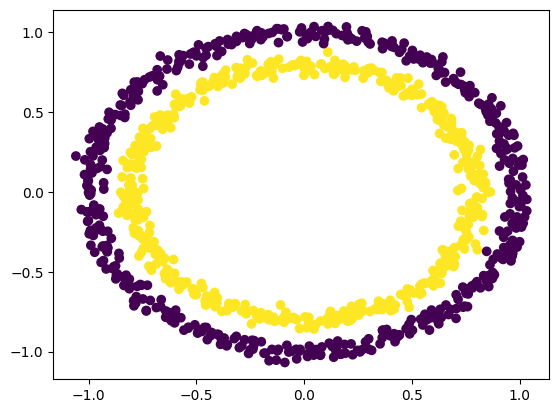

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],y=X[:,1],c=y)

### 1.1 Check input and output shapes

In [ ]:
X.shape,y.shape

((1000, 2), (1000,))

In [ ]:
X[0].shape,y[0].shape

((2,), ())

## 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch
torch.__version__

'2.5.1+cu124'

In [ ]:
torch.float

torch.float32

In [ ]:
X.dtype

dtype('float64')

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X[:5],y[:5]
torch.manual_seed(42)

In [ ]:
# Split data into training data into train and test
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
len(X_train),len(X_test)

(800, 200)

## 2. Building a model

To do so, we want to:

1. Setup device agonistic code so our code will run on accelerator (GPU) if there is one
2. Construct a model (by subclass by nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class CirclesModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x))


model_0 = CirclesModelV0().to(device)
model_0

CirclesModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [ ]:
model_0.eval()
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
len(untrained_preds),untrained_preds.shape

(200, torch.Size([200, 1]))

In [ ]:
print(f'First 10 predictions: \n{untrained_preds[:10]}')
print(f'First 10 labels: \n{y_test[:10]}')

First 10 predictions: 
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')
First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)

In [ ]:
def accuracy(y_pred,y_true):
  correct = torch.eq(y_pred,y_true).sum().item()
  return (correct/len(y_pred))*100

## 3. Train model

### 3.1 Going from raw logits -> predictions probabilities -> prediction labels
 Our model outputs are going to be raw **logits**

 We can convert these **logits** into **predictionss probabilities** by passing them to some kind of activation function (e.g sigmoid for binary, softmax for multi)

Then we can convert our model's predictions prob to **prediction labels** by either rounding them or taking `argmax()`

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [ ]:
# Use the sigmoid activation function on our model predict to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probability values, we need to perfomrm a range-style rounding on them:
* y_pred_probs >= 0.5 -> y=1
* y_pred_probs < 0.5 -> y=0

In [ ]:
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_labels

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
      

### 3.2 Building a training and testing loop

In [ ]:
torch.cuda.manual_seed(42)

In [ ]:
epochs = 500

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):

  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss
  # loss = loss_fn(torch.sigmoid(y_logits)) # nn.BCELoss expects prediction probabilities as input
  loss = loss_fn(y_logits,y_train) # nn.BCEWithLogitsLoss expects raw logits as input

  # Zero grad
  optimizer.zero_grad()

  # Backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    y_logits_test = model_0(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))
    test_loss = loss_fn(y_logits_test,y_test)
    acc = accuracy(y_test,y_pred_test)

  if epoch % 10 == 0:
    print(f"Epoch :{epoch} | Accuracy : {acc} | Test loss : {test_loss}")




Epoch :0 | Accuracy : 57.49999999999999 | Test loss : 0.6945955753326416
Epoch :10 | Accuracy : 57.99999999999999 | Test loss : 0.6943801045417786
Epoch :20 | Accuracy : 57.49999999999999 | Test loss : 0.6941846013069153
Epoch :30 | Accuracy : 56.49999999999999 | Test loss : 0.6940073370933533
Epoch :40 | Accuracy : 56.49999999999999 | Test loss : 0.6938462853431702
Epoch :50 | Accuracy : 56.00000000000001 | Test loss : 0.6937000155448914
Epoch :60 | Accuracy : 56.00000000000001 | Test loss : 0.693567156791687
Epoch :70 | Accuracy : 56.49999999999999 | Test loss : 0.6934463381767273
Epoch :80 | Accuracy : 56.49999999999999 | Test loss : 0.6933364868164062
Epoch :90 | Accuracy : 55.00000000000001 | Test loss : 0.6932365894317627
Epoch :100 | Accuracy : 54.0 | Test loss : 0.693145751953125
Epoch :110 | Accuracy : 53.0 | Test loss : 0.6930630207061768
Epoch :120 | Accuracy : 52.5 | Test loss : 0.6929877996444702
Epoch :130 | Accuracy : 52.0 | Test loss : 0.6929193139076233
Epoch :140 | Ac

## 4. Make predictions and evaluation



In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/yusnivtr/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py",'wb') as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions


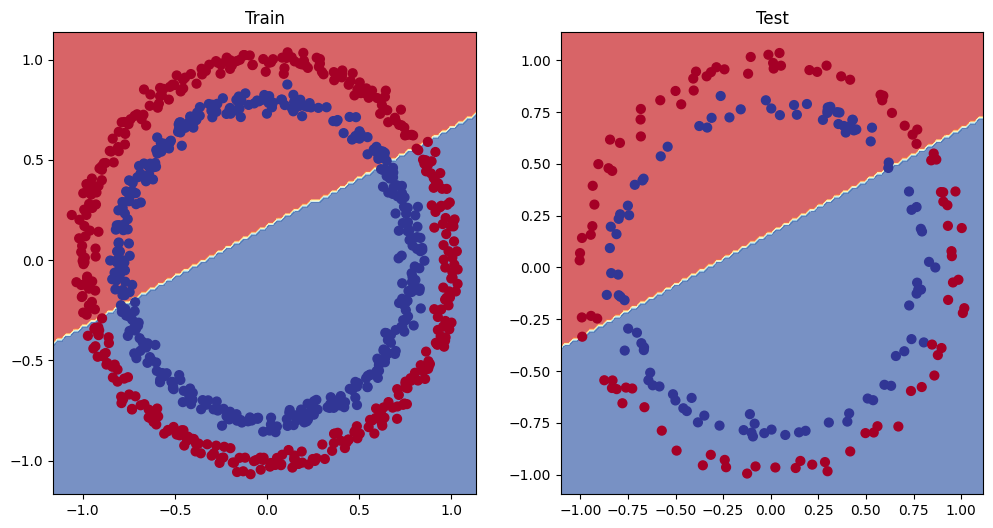

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## 5. Improving a model

* Add more layers - give the model more chances to learn patterns in the data
* Add more hidden units - go from 5 hidden units 10 hidden units
* Fit for longer
* Changing the activations functions
* Change the learning rate
* Change the loss function

These options are all from a model's perpective because they deal directly with the model, rather than the data.

And cause these options are all values we can change, they are referred as **hyperparametes**.


In [ ]:
class CirclesModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CirclesModelV1()
model_1

CirclesModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Traning for longer
epochs = 1000

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  logits = model_1(X_train).squeeze()
  preds = torch.round(torch.sigmoid(logits))

  loss = loss_fn(logits,y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)

    acc = accuracy(test_preds,y_test)

  if epoch % 10 == 0:
    print(f"Epoch : {epoch} | Accuracy : {acc} | Test loss : {test_loss}")




Epoch : 0 | Accuracy : 50.0 | Test loss : 0.6959357857704163
Epoch : 10 | Accuracy : 50.0 | Test loss : 0.6942470669746399
Epoch : 20 | Accuracy : 54.0 | Test loss : 0.6936600804328918
Epoch : 30 | Accuracy : 56.00000000000001 | Test loss : 0.6934545636177063
Epoch : 40 | Accuracy : 55.50000000000001 | Test loss : 0.693378746509552
Epoch : 50 | Accuracy : 55.00000000000001 | Test loss : 0.6933476328849792
Epoch : 60 | Accuracy : 54.50000000000001 | Test loss : 0.6933334469795227
Epoch : 70 | Accuracy : 54.50000000000001 | Test loss : 0.693327784538269
Epoch : 80 | Accuracy : 53.5 | Test loss : 0.693327784538269
Epoch : 90 | Accuracy : 53.0 | Test loss : 0.6933327913284302
Epoch : 100 | Accuracy : 54.0 | Test loss : 0.6933419108390808
Epoch : 110 | Accuracy : 53.5 | Test loss : 0.6933548450469971
Epoch : 120 | Accuracy : 54.50000000000001 | Test loss : 0.6933709383010864
Epoch : 130 | Accuracy : 54.0 | Test loss : 0.6933900117874146
Epoch : 140 | Accuracy : 51.5 | Test loss : 0.69341123

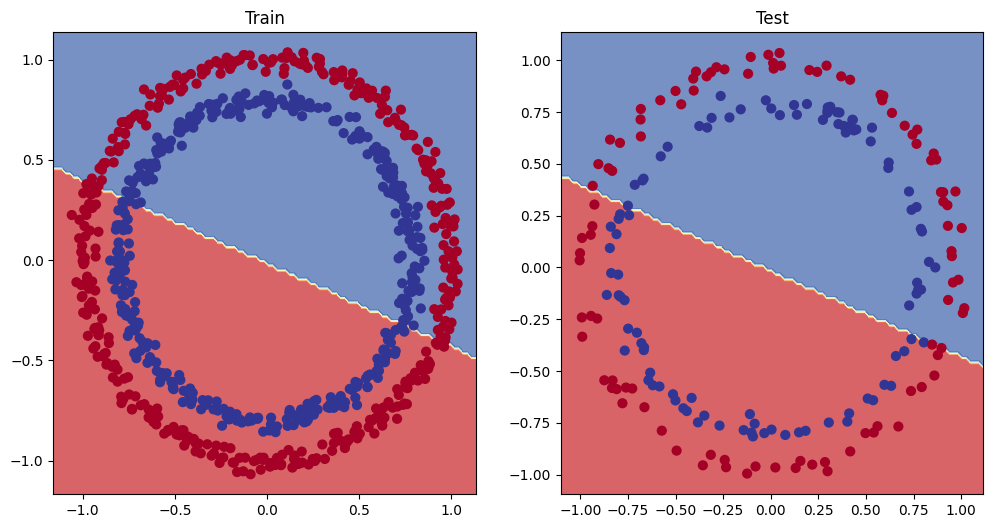

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

### 5.1 Preparing data to see if our model can fit a straight line

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


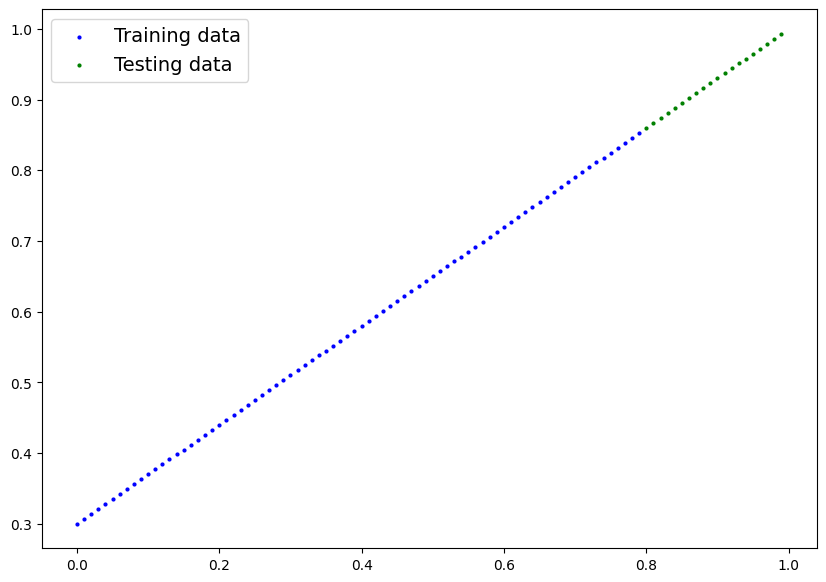

In [ ]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

### 5.2 Adjust model to fit a straight line

In [ ]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(lr=0.01,
                            params=model_2.parameters())

In [ ]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.91103
Epoch: 100 | Train loss: 0.02858, Test loss: 0.00081
Epoch: 200 | Train loss: 0.02533, Test loss: 0.00209
Epoch: 300 | Train loss: 0.02137, Test loss: 0.00305
Epoch: 400 | Train loss: 0.01964, Test loss: 0.00341
Epoch: 500 | Train loss: 0.01940, Test loss: 0.00387
Epoch: 600 | Train loss: 0.01903, Test loss: 0.00379
Epoch: 700 | Train loss: 0.01878, Test loss: 0.00381
Epoch: 800 | Train loss: 0.01840, Test loss: 0.00329
Epoch: 900 | Train loss: 0.01798, Test loss: 0.00360


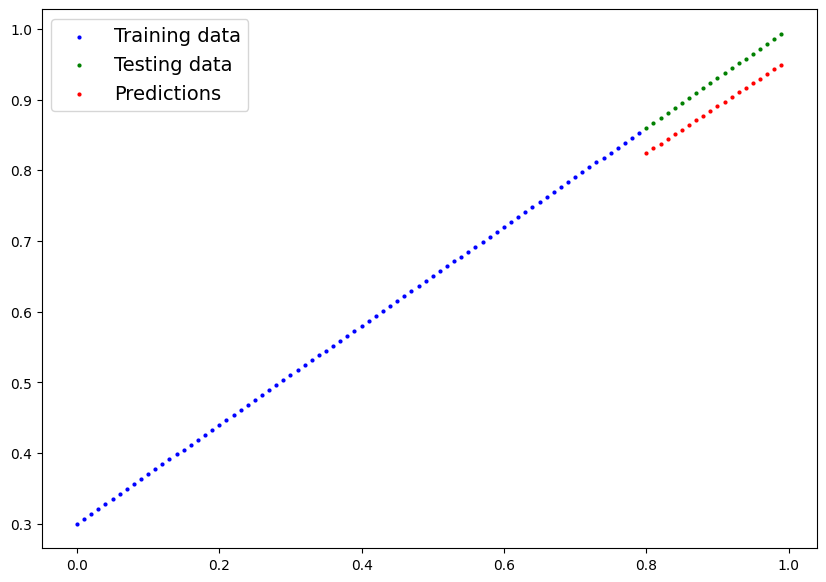

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity




### 6.1 Recreating non-linear data

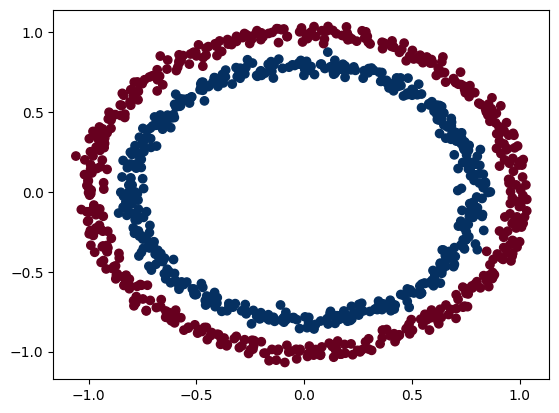

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples=1000,noise=0.03,random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdBu)

### 6.2 Building a model with non-linearity

In [ ]:
import torch
from sklearn.model_selection import train_test_split

X  = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

X_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    # Intersperse the ReLU activation function between layers
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.1)

### 6.3 Traning a model with non-linearity


In [ ]:
torch.manual_seed(42)
epochs = 1000

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  # Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss and accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy(y_true=y_train,y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy(y_test,test_pred)

  if epoch % 100 == 0:
    print(f"Epoch : {epoch} | Loss: {loss:.5f} | Accuracy : {test_acc}")


Epoch : 0 | Loss: 0.69295 | Accuracy : 50.0
Epoch : 100 | Loss: 0.69115 | Accuracy : 52.5
Epoch : 200 | Loss: 0.68977 | Accuracy : 55.00000000000001
Epoch : 300 | Loss: 0.68795 | Accuracy : 56.00000000000001
Epoch : 400 | Loss: 0.68517 | Accuracy : 56.49999999999999
Epoch : 500 | Loss: 0.68102 | Accuracy : 56.49999999999999
Epoch : 600 | Loss: 0.67515 | Accuracy : 56.00000000000001
Epoch : 700 | Loss: 0.66659 | Accuracy : 59.0
Epoch : 800 | Loss: 0.65160 | Accuracy : 67.5
Epoch : 900 | Loss: 0.62362 | Accuracy : 79.0


### 6.4 Evaluating a model trained with non-linear activation functions

Text(0.5, 1.0, 'Non-linear Model')

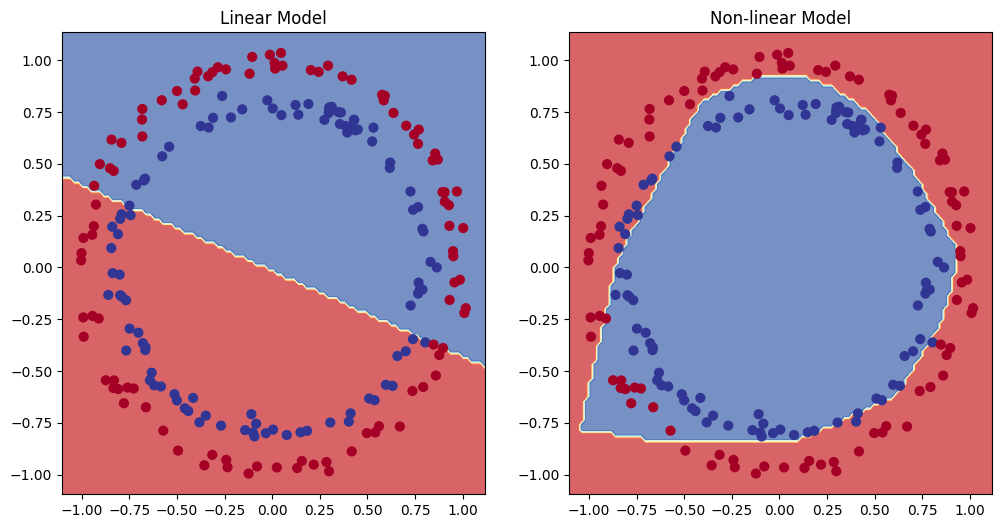

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_1,X_test,y_test)
plt.title("Linear Model")

plt.subplot(1,2,2)
plot_decision_boundary(model_3,X_test,y_test)
plt.title("Non-linear Model")



## 7. Replicating non-linear activation functions


In [ ]:
A = torch.arange(-10,10,1,dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

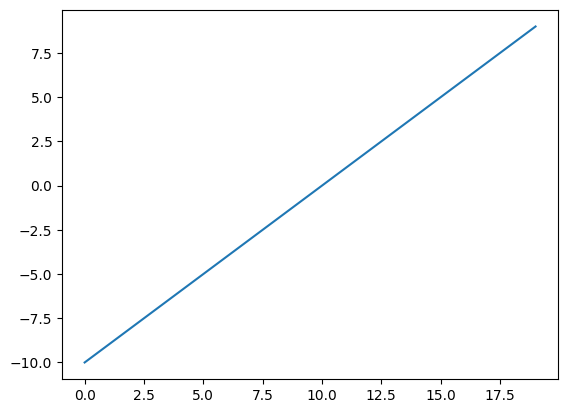

In [ ]:
plt.plot(A)

In [ ]:
def relu(x):
  return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

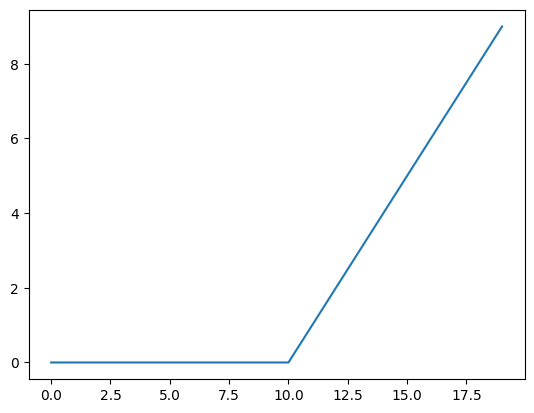

In [ ]:
plt.plot(relu(A))

In [ ]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

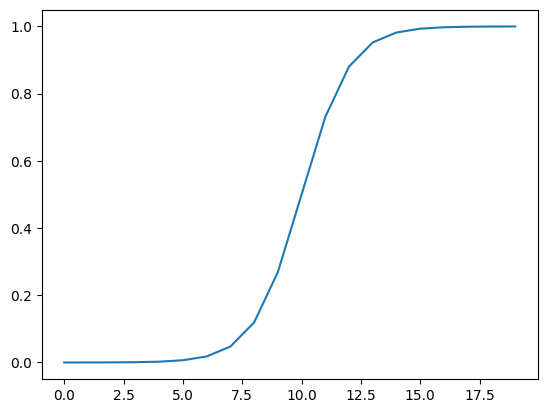

In [ ]:
plt.plot(sigmoid(A))

## 8. Putting things together by building a multi-class PyTorch model

### 8.1 Creating multi-class classification data

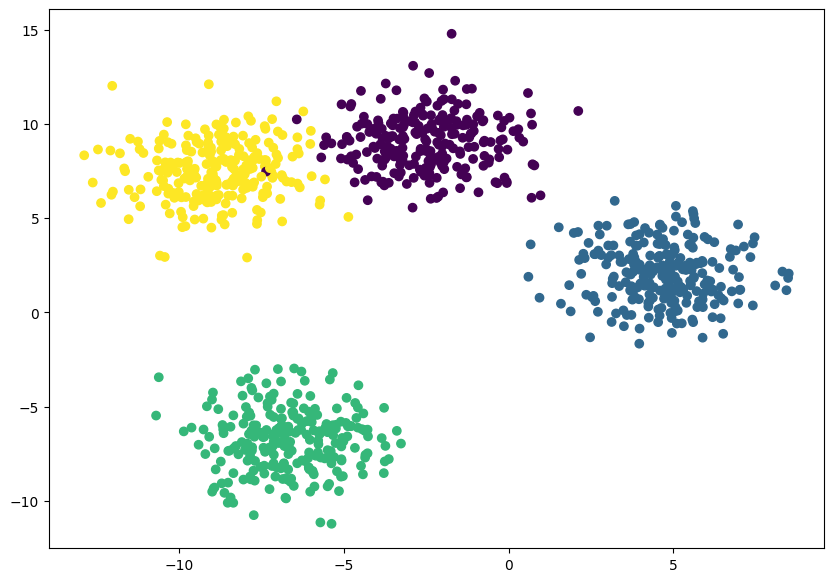

In [ ]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob)

### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),lr=0.1)

In [ ]:
tmp = model_4(X_blob_train.to(device))[:5]
tmp

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
torch.softmax(tmp,dim=1)

tensor([[0.1838, 0.3422, 0.1500, 0.3239],
        [0.2199, 0.0377, 0.1839, 0.5586],
        [0.3406, 0.0482, 0.5326, 0.0785],
        [0.3405, 0.0657, 0.4446, 0.1492],
        [0.2527, 0.0424, 0.2283, 0.4766]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
torch.sum(torch.softmax(tmp,dim=1)[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
torch.manual_ssed(42)

epochs = 1000

X_blob_train,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

  model_4.train()

